In [1]:

#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
# import pandas.stats.moments as st
import statsmodels.api as sm # import statsmodels 
from pandas import ExcelWriter
import matplotlib.pyplot as pyplot
import scipy.stats as st
import os
import quandl as qd
from collections import defaultdict
import seaborn as sns
%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

C:\Users\xexx\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
btc = qd.get("BITFINEX/BTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
btc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

eth = qd.get("BITFINEX/ETHUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
eth.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

ltc = qd.get("BITFINEX/LTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
ltc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

neo = qd.get("BITFINEX/NEOUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
neo.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

etc = qd.get("BITFINEX/ETCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
etc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

xmr = qd.get("BITFINEX/XMRUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
xmr.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

zec = qd.get("BITFINEX/ZECUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
zec.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

omg = qd.get("BITFINEX/OMGUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
omg.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

In [11]:
def ichimoku_cloud(df,w9,w26,w52,chikou26):
    #crypto settings are 20, 60, 120, 30 see Josh video for confirmation
    #https://www.youtube.com/watch?v=5x0r-qcGoQQ&t=1s
    
    
    # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
    df['period9_high'] = pd.Series.rolling(df['High'], w9).max()
    df['period9_low'] = pd.Series.rolling(df['Low'], w9).min()
    df['tenkan_sen'] = (df['period9_high'] + df['period9_low']) / 2
    
    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    df['period26_high'] = pd.Series.rolling(df['High'], w26).max()
    df['period26_low'] = pd.Series.rolling(df['Low'], w26).min()
    df['kijun_sen'] = (df['period26_high'] + df['period26_low']) / 2
    
    df['period52_high'] = pd.Series.rolling(df['High'], w52).max()
    df['period52_low'] = pd.Series.rolling(df['Low'], w52).min()
    df['senkou_span_a'] = (df['tenkan_sen'] + df['kijun_sen']) / 2
    df['senkou_span_b'] = (df['period52_high'] + df['period52_low'] ) /2 
    
    df ['chikou_span'] = df['Close'].shift(chikou26) 
    return df


In [12]:
neo.head(10)

,High,Low,Mid,Close,Bid,Ask,Volume
Date,,,,,,,
2017-09-07,39.800,22.300,30.5525,30.411,30.415,30.690,269772.012257
2017-09-08,31.637,22.320,25.9525,25.900,25.912,25.993,291852.004274
2017-09-09,26.270,22.180,23.3955,23.351,23.358,23.433,139533.241697
2017-09-10,25.400,19.529,24.0725,24.202,23.943,24.202,175813.285869
2017-09-11,24.500,21.509,21.9105,21.880,21.873,21.948,79686.038107
2017-09-12,23.800,19.880,20.8865,20.801,20.806,20.967,148076.452223
2017-09-13,21.395,17.534,20.5725,20.507,20.442,20.703,141692.110832
2017-09-14,20.986,14.700,16.5580,16.744,16.510,16.606,167425.957702
2017-09-15,19.330,13.190,18.8075,18.860,18.755,18.860,244785.042573


In [13]:
ichimoku_cloud(btc,20,60,120,30) #crypto settings
#ichimoku_cloud(btc,9,26,52,26) #default settings 
btc = btc.dropna()

ichimoku_cloud(eth,20,60,120,30) #crypto settings
#ichimoku_cloud(btc,9,26,52,26) #default settings 
eth = eth.dropna()

ichimoku_cloud(neo,20,60,120,30) #crypto settings
#ichimoku_cloud(btc,9,26,52,26) #default settings 
neo = neo.dropna()

In [5]:

def returns_df(df):
    df['tk position'] = None
    df['tk senkou b position'] = None
    df['tk senkou a position'] = None
    df['tk and senkou a'] = None
    
    for row in range(len(df)):
        if df['tenkan_sen'].iloc[row] > df['kijun_sen'].iloc[row]:
            df['tk position'].iloc[row] = 1
        else:
            df['tk position'].iloc[row] = -1

    for row in range(len(df)):
        if df['Close'].iloc[row] > df['senkou_span_b'].iloc[row]:
            df['tk senkou b position'].iloc[row] = 1
        else:
            df['tk senkou b position'].iloc[row] = -1

    for row in range(len(df)):
        if df['Close'].iloc[row] > df['senkou_span_a'].iloc[row]:
            df['tk senkou a position'].iloc[row] = 1
        else:
            df['tk senkou a position'].iloc[row] = -1
            
    for row in range(len(df)):
        if df['tk position'].iloc[row] == 1 and df['tk senkou a position'].iloc[row] == 1:
            df['tk and senkou a'].iloc[row] = 1
        else:
            df['tk and senkou a'].iloc[row] = -1
            
            
    df['tk position'].fillna(method = 'ffill', inplace = True)
    df['tk senkou b position'].fillna(method = 'ffill', inplace = True)
    df['tk senkou a position'].fillna(method = 'ffill', inplace = True)
    df['tk and senkou a'].fillna(method = 'ffill', inplace = True)
    
    df['market return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['strategy return tk'] = df['tk position'] * df['market return']
    df['strategy return senkou b'] = df['tk senkou b position'] * df['market return']
    df['strategy return senkou a'] = df['tk senkou a position'] * df['market return']
    df['strategy return tk and senkou a'] = df['tk and senkou a'] * df['market return']
    
    df['strategy return tk'].cumsum().plot(grid = True, figsize = (20,5), color = 'g') #tk cross
    df['strategy return senkou b'].cumsum().plot(grid = True, figsize = (20,5), color = 'b') #price above lag
    df['strategy return senkou a'].cumsum().plot(grid = True, figsize = (20,5), color = 'r') #price above senkou a
    df['strategy return tk and senkou a'].cumsum().plot(grid = True, figsize = (20,5), color = 'y') #price above senkour a AND tk cross
    df['market return'].cumsum().plot(grid = True, figsize = (20,5), color = 'm') #market return if held
    
            
    return None

C:\Users\xexx\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


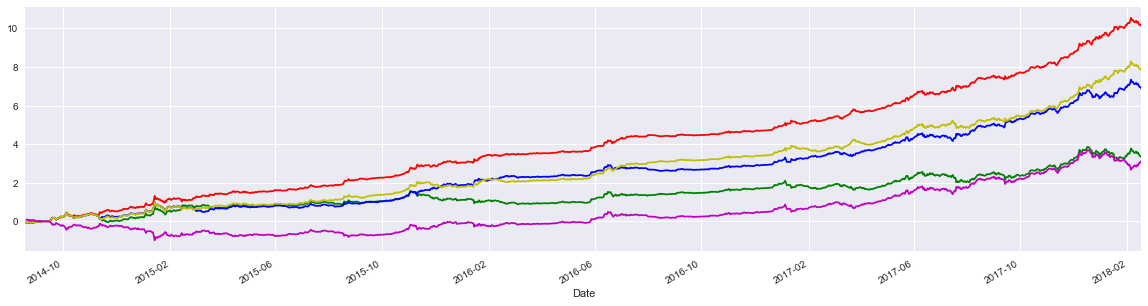

In [6]:
returns_df(btc)


C:\Users\xexx\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


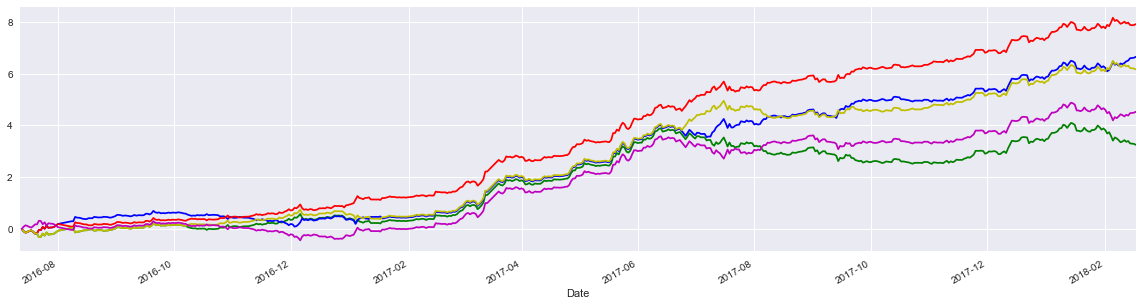

In [7]:
returns_df(eth)

In [14]:
neo.head(10)

,High,Low,Mid,Close,Bid,Ask,Volume,period9_high,period9_low,tenkan_sen,period26_high,period26_low,kijun_sen,period52_high,period52_low,senkou_span_a,senkou_span_b,chikou_span
Date,,,,,,,,,,,,,,,,,,


In [ ]:
btc['senkou_span_a'].plot(color = 'g', figsize = (20,5))
btc['senkou_span_b'].plot(color = 'm', figsize = (20,5))
btc['Close'].plot()